In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

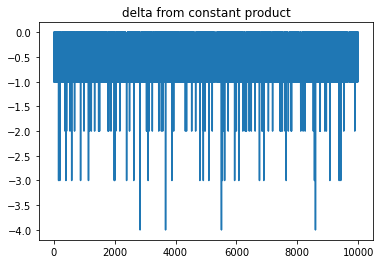

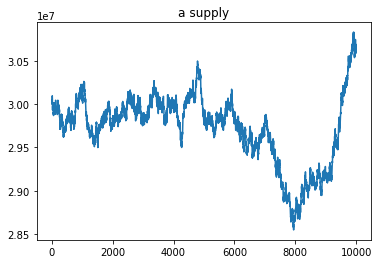

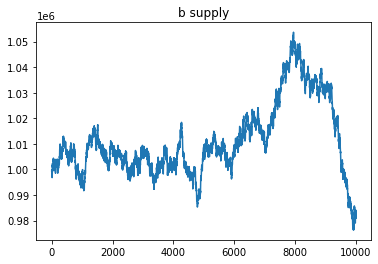

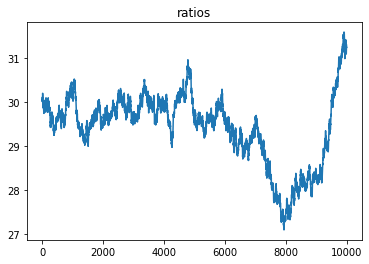

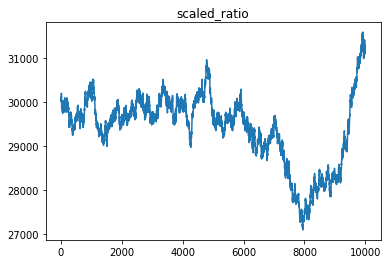

In [11]:
from constant_product_amm import Simulator

sim = Simulator()
sim.run(num=10000)

plt.title("delta from constant product")
plt.plot(sim.deltas)
plt.show()

plt.title("a supply")
plt.plot(sim.a_supply)
plt.show()

plt.title("b supply")
plt.plot(sim.b_supply)
plt.show()

plt.title("ratios")
plt.plot(sim.ratios)
plt.show()

plt.title("scaled_ratio")
plt.plot(sim.scaled_ratios)
plt.show()